
LOOKING AT EPOCH = 50, LEARNING_RATE = 0.1 


LOOKING AT EPOCH = 200, LEARNING_RATE = 0.1 


LOOKING AT EPOCH = 500, LEARNING_RATE = 0.1 


LOOKING AT EPOCH = 50, LEARNING_RATE = 0.01 


LOOKING AT EPOCH = 200, LEARNING_RATE = 0.01 


LOOKING AT EPOCH = 500, LEARNING_RATE = 0.01 


LOOKING AT EPOCH = 50, LEARNING_RATE = 0.001 


LOOKING AT EPOCH = 200, LEARNING_RATE = 0.001 


LOOKING AT EPOCH = 500, LEARNING_RATE = 0.001 


FINAL RESULTS:


[Epoch: 50, Learning Rate: 0.1
Average Train Loss: 0.03242417210625718
Average Validation Loss: 0.1472292456287201

[Epoch: 200, Learning Rate: 0.1
Average Train Loss: 0.017288610534494302
Average Validation Loss: 0.1860481920445197

[Epoch: 500, Learning Rate: 0.1
Average Train Loss: 0.012864934003280823
Average Validation Loss: 0.22744369448707918

[Epoch: 50, Learning Rate: 0.01
Average Train Loss: 0.09935073153565532
Average Validation Loss: 0.15169183660743799

[Epoch: 200, Learning Rate: 0.01
Average Train Loss: 0.05201521823888676
Average V

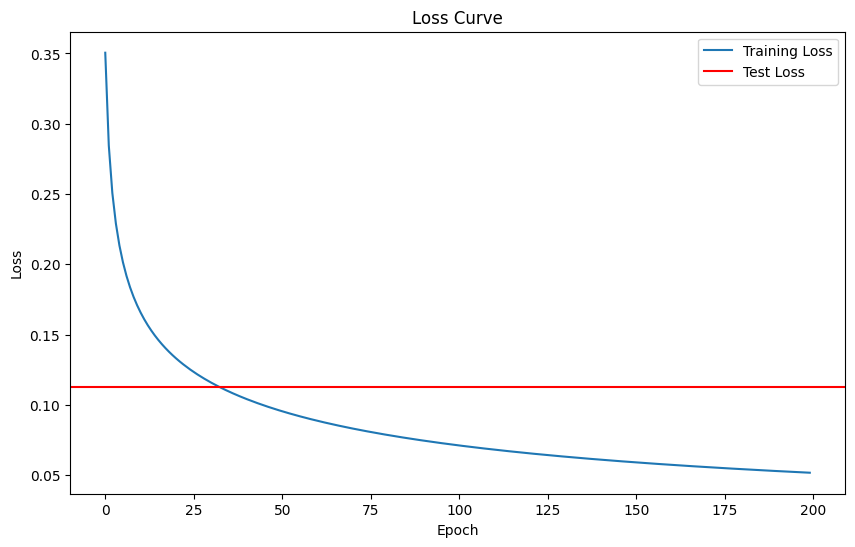

In [2]:
import pandas as pd
import numpy as np
from sklearn.model_selection import KFold, train_test_split
import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score, f1_score

# Load data
trainingArr = pd.read_csv('./train_midterm.csv')
testArr = pd.read_csv('./test_midterm.csv')

x_test = testArr.drop('label', axis=1).values
y_test = testArr['label'].values
x_train = trainingArr.drop('label', axis=1).values
y_train = trainingArr['label'].values

# Hyperparameters to tune
allPossibleLearning_rate = [0.1, 0.01, 0.001]
allPossibleEpochs = [50, 200, 500]

def findLossForDataSet(xData, yData, weights):
    # Calculate the predicted probabilities
    z = np.dot(xData, weights)
    yHat = 1 / (1 + np.exp(-z))
    
    # dding small constant (1e-100) to stop log(0) error from occuring
    loss = -np.mean(yData * np.log(yHat + 1e-100) + (1 - yData) * np.log(1 - yHat+1e-100))
    return loss

def perform_Logistic_Regression(xTrain, yTrain, xVal, yVal, epoch, learningRate):
    trainingLoss = []
    valLoss = []
    weights = np.zeros(xTrain.shape[1])
    
    for ep in range(epoch):
        # do stochastic gradient descent
        for i in range(len(xTrain)):
            xRow = xTrain[i]
            y_true = yTrain[i]
            
            # find your prediction value based on your current weights
            oldyHat = np.dot(weights, xRow)

            # need to transform your original yHat into value between 0-1 since this is a classification model
            yHat = 1 / (1 + np.exp(-oldyHat))
            
            gradient = (yHat - y_true) * xRow
            
            # updatate weights after each row, property of SGD
            weights = weights - learningRate * gradient
        
        # find losses at the end of each epoch
        train_loss = findLossForDataSet(xTrain, yTrain, weights)
        trainingLoss.append(train_loss)
        if xVal is not None:
            val_loss = findLossForDataSet(xVal, yVal, weights)
            valLoss.append(val_loss)


        # only returning validation loss if there is a validation set provided.
    if xVal is not None:
        return trainingLoss[-1], valLoss[-1], trainingLoss, valLoss, weights
    else:
        return trainingLoss[-1], None, trainingLoss, None, weights
            



def perform_cross_validation(x_train, y_train, epoch, learningRate):
    print(f"\nLOOKING AT EPOCH = {epoch}, LEARNING_RATE = {learningRate} \n")
    fold_train_losses = []
    fold_val_losses = []
    kf = KFold(n_splits=5, shuffle=True, random_state=42)
    
    #splitting data into 5 blocks and using validation and training data to find averageValidationLoss and avgTrainingLoss for each hyperparameter
    for (train_index, val_index) in (kf.split(x_train)):
        x_train_fold = x_train[train_index]
        y_train_fold = y_train[train_index]
        x_val_fold = x_train[val_index]
        y_val_fold = y_train[val_index]

        # Find trainingloss and validation loss with given validation and training sets.
        trainLoss, valLoss, ignore, ignore, ignore = perform_Logistic_Regression(x_train_fold, y_train_fold, x_val_fold, y_val_fold, epoch, learningRate)
        fold_train_losses.append(trainLoss)
        fold_val_losses.append(valLoss)
    
    meanTrainLoss = np.mean(fold_train_losses)
    meanValLoss = np.mean(fold_val_losses)
    
    return meanTrainLoss, meanValLoss

# do cross-validation for all hyperparameter combinations
results = []

for learningRate in allPossibleLearning_rate:
    for epoch in allPossibleEpochs:
        curMeanTrainLoss, curMeanValLoss = perform_cross_validation(x_train, y_train, epoch, learningRate)
        
        results.append({'learningRate': learningRate, 'epoch': epoch, 'meanTrainLoss': curMeanTrainLoss, 'meanValLoss': curMeanValLoss})

print("\nFINAL RESULTS:\n")
for result in results:
    print(f"\n[Epoch: {result['epoch']}, Learning Rate: {result['learningRate']}")
    print(f"Average Train Loss: {result['meanTrainLoss']}")
    print(f"Average Validation Loss: {result['meanValLoss']}")

# Find best hyperparameter based on validation loss
curMinVal = float('inf')
curBestObj = None
for result in results:
    if result["meanValLoss"] < curMinVal:
        curMinVal = result["meanValLoss"]
        curBestObj = result

print("\nBEST HYPERPARAMETERS")
print(f"Epoch: {curBestObj['epoch']}")
print(f"Learning Rate: {curBestObj['learningRate']}")
print(f"Average Validation Loss: {curBestObj['meanValLoss']}")
print(f"Average Training Loss {curBestObj['meanTrainLoss']}")

#doing final training on entire dataset and use the best hyperparameter you found with cross fold validation
print("\nTraining final model with best hyperparameters on full dataset")
#setting both the xVal and yVal set as 'None' since we're not finding the validation loss in this final training.
ignore, ignore, train_loss_history, ignore, bestWeights = perform_Logistic_Regression(x_train, y_train, None, None, curBestObj['epoch'], curBestObj['learningRate'])


#finding test loss after all training using best weights
testLoss = findLossForDataSet(x_test, y_test, bestWeights)
print(f"\n Final Test Loss = {testLoss}")

z_test = np.dot(x_test, bestWeights)
y_pred_prob = 1 / (1 + np.exp(-z_test))
# for each value in the y-pred array if its >= 1 then it becomes a true boolean, casting it into an int will equal 1.
y_pred = (y_pred_prob >= 0.5).astype(int) 

# finding accuracy and F1 score
test_accuracy = accuracy_score(y_test, y_pred)
test_f1 = f1_score(y_test, y_pred)

print(f"\nFinal Test Loss = {testLoss}")
print(f"Test Accuracy = {test_accuracy:.4f}")
print(f"Test F1 Score = {test_f1:.4f}")


plt.figure(figsize=(10, 6))
plt.plot(train_loss_history, label='Training Loss')
plt.axhline(y=testLoss, color="red", label='Test Loss')
# plt.plot(val_loss_history, label='Validation Loss')
plt.title(f'Loss Curve')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()